In [1]:
import os
import statistics
from typing import Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


In [2]:
def load_csv_results():
    normal_scenarios = ["data_corruption", "data_cleaning"]
    normal_datasets = ["reviews"]
    # data_loadings = ["fast_loading", "slow_loading"]
    data_loadings = ["fast_loading"]
    featurizations = ["featurization_1"]
    models = ["logistic_regression"]
    result_df = None
    for scenario in normal_scenarios:
        for dataset in normal_datasets:
            for data_loading in data_loadings:
                for featurization in featurizations:
                    for model in models:
                        filepath = f"{os.getcwd()}/manual-analysis-benchmark-results/" \
                                   f"results-{scenario}-{dataset}-{data_loading}-{featurization}-{model}.csv"
                        new_df = pd.read_csv(filepath)
                        median_no_opt = new_df['total_exec_duration_without_opt'].median()
                        new_df['median_manual'] = new_df['total_exec_duration_manual'].median()
                        new_df['median_no_opt'] = median_no_opt
                        median_opt = new_df['total_exec_duration_with_opt'].median()
                        new_df['median_opt'] = median_opt
                        new_df['median_opt_plan_generation'] = new_df['opt_what_if_plan_generation'].median()
                        new_df['median_opt_mqo'] = new_df['opt_what_if_query_optimization_duration'].median()
                        new_df['median_opt_other_runtime'] = new_df['total_exec_duration_with_opt'].median() - \
                                                             new_df['opt_original_pipeline_without_importing_and_monkeypatching'].median() - \
                                                             new_df['opt_original_pipeline_importing_and_monkeypatching'].median() - new_df['opt_what_if_execution'].median()
                        median_speedup = median_no_opt / median_opt
                        new_df['median_speedup'] = median_speedup
                        new_df['opt_original_pipeline_estimated'] = new_df['opt_original_pipeline_estimated'].median()
                        new_df['median_original_with_instrum'] = (new_df['opt_original_pipeline_without_importing_and_monkeypatching'] +
                                                                  new_df['opt_original_pipeline_importing_and_monkeypatching']).median()
                        new_df['median_model_training_opt'] = new_df['opt_original_pipeline_model_training'].median() \
                                                              + new_df['opt_what_if_execution_combined_model_training'].median()
                        new_df['median_model_training_no_opt'] = new_df['opt_original_pipeline_model_training'].median() \
                                                              + new_df['no_opt_what_if_execution_combined_model_training'].median()
                        new_df['median_no_opt_wo_orig'] = new_df['median_no_opt'] - new_df['median_original_with_instrum']
                        new_df['median_opt_wo_orig'] = new_df['median_opt'] - new_df['median_original_with_instrum']
                        new_df['median_opt_wo_training'] = new_df['median_opt'] - new_df['median_model_training_opt']
                        new_df['median_no_opt_wo_training'] = new_df['median_no_opt'] - \
                                                              new_df['median_model_training_no_opt']
                        new_df['median_speedup_excluding_model_training'] = new_df['median_no_opt_wo_training'] / \
                                                                            new_df['median_opt_wo_training']
                        # for column in new_df.columns:
                        #     if column.startswith("analysis_result"):
                        #         new_df[column] = median_no_opt / new_df[column].median()
                        new_df['variant_count_including_orig'] = new_df['variant_count'] + 1
                        new_df['max_possible_speedup'] = new_df['variant_count_including_orig'] / 2
                        new_df = new_df[['median_no_opt', 'median_opt', 'median_manual', 'median_speedup',
                                         'median_original_with_instrum',
                                         'median_speedup_excluding_model_training',
                                         'median_no_opt_wo_orig', 'median_opt_wo_orig',
                                         'median_opt_plan_generation', 'median_opt_mqo', 'median_opt_other_runtime',
                                         'opt_original_pipeline_estimated', 'variant_count_including_orig',
                                         'max_possible_speedup', 'scenario', 'dataset',
                                         'data_loading', 'featurization', 'model']]
                        new_df = new_df.head(1)
                        new_df = new_df.round(2)
                        if result_df is None:
                            result_df = new_df
                        else:
                            result_df = pd.concat([result_df, new_df], axis=0)
    return result_df

In [3]:
median_results = load_csv_results()

   median_no_opt  median_opt  median_manual  median_speedup  \
0      140105.72    21680.83      118141.02            6.46   
0      140105.72    21680.83      118141.02            6.46   
0      140105.72    21680.83      118141.02            6.46   
0      108374.07    28977.66       91840.91            3.74   
0      108374.07    28977.66       91840.91            3.74   
0      108374.07    28977.66       91840.91            3.74   

   median_original_with_instrum  median_speedup_excluding_model_training  \
0                       5147.46                                     6.39   
0                       5147.46                                     6.39   
0                       5147.46                                     6.39   
0                       5133.56                                     4.02   
0                       5133.56                                     4.02   
0                       5133.56                                     4.02   

   median_no_opt_wo_orig 

/var/folders/1x/7tjtf92157d00yflbr4s67f80000gn/T/ipykernel_44319/1540881814.py:31: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  bars = plt.bar([position + 1], np.median(values_to_plot_without), width=1., color=color_without, hatch="/  ", edgecolor='white')


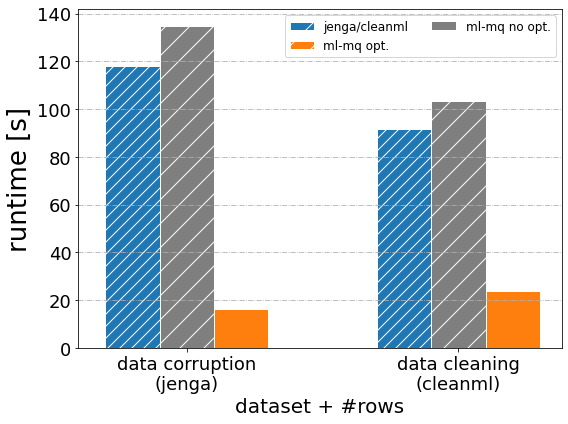

In [4]:
def speedup_bar_plot(data, title, group_col_1, group_col_2, plot_column):
    fig, ax = plt.subplots()
    # ax.set_yscale('log')

    classes_col1 = list(data[group_col_1].unique())
    classes_col2 = list(data[group_col_2].unique())

    colors = ['tab:blue', 'tab:grey', 'tab:orange', 'tab:blue', 'tab:grey', 'tab:orange']

    position = 1

    def triplewise(iterable):
        "s -> (s0, s1, s3), (s4, s5, s6), ..."
        a = iter(iterable)
        return zip(a, a, a)

    for group1_index, group1_val in enumerate(classes_col1):
        filtered1_data = data[data[group_col_1] == group1_val]

        for (group2_val_manual, color_manual), (group2_val_without, color_without), (group2_val_with, color_with) \
                in triplewise(zip(classes_col2, colors)):
            filtered2_data_manual = filtered1_data[filtered1_data[group_col_2] == group2_val_manual]
            values_to_plot_manual = filtered2_data_manual[plot_column]
            filtered2_data_without = filtered1_data[filtered1_data[group_col_2] == group2_val_without]
            values_to_plot_without = filtered2_data_without[plot_column]
            filtered2_data_with = filtered1_data[filtered1_data[group_col_2] == group2_val_with]
            values_to_plot_with = filtered2_data_with[plot_column]

            if len(values_to_plot_without) > 0:
                bars = plt.bar([position], np.median(values_to_plot_manual), width=1., color=color_manual, hatch="//", edgecolor='white')
                bars = plt.bar([position + 1], np.median(values_to_plot_without), width=1., color=color_without, hatch="/  ", edgecolor='white')
                bars = plt.bar([position + 2], np.median(values_to_plot_with), width=1., color=color_with, hatch=None, edgecolor='white')
            position += 3
        position += 2
    # ax.legend(fontsize=15, ncol=1)
    # ax.grid(True)
    plt.gca().yaxis.grid(True, linestyle='-.')
    plt.ylabel('runtime [s]', fontsize=26)
    plt.ylim(0, None)
    plt.xlabel('dataset + #rows', fontsize=20)
    plt.xlim(0, None)
    ax.set_xticks([2 + (len(classes_col2) + 2) * group1_index for group1_index, _ in enumerate(classes_col1)])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticklabels(classes_col1, fontsize=18)

    handles1 = []
    handles2 = []
    for class_index, (class2, color) in enumerate(zip(classes_col2, colors)):
        if (class_index % 2) == 0:
            handles1.append(patches.Patch(facecolor=color,edgecolor='white', hatch="/",label=class2))
        else:
            handles2.append(patches.Patch(facecolor=color,hatch=None,label=class2))

    plt.legend(fontsize=12, handles=handles1 + handles2, loc="upper right", ncol=2)

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

scenario_names = {
    'feature_importance': 'feature importance',
    'operator_impact': 'operator impact',
    'data_cleaning': 'data cleaning\n(cleanml)',
    'data_corruption': 'data corruption\n(jenga)',
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)

manual = pretty_scenario_names.copy()
manual['runtime'] = manual['median_manual'] / 1000
manual['exec_variant'] = "jenga/cleanml"
# manual.loc[manual['scenario'] == 'data cleaning', 'exec_variant'] = "jenga/cleanml"
# manual.loc[manual['scenario'] == 'data corruption', 'exec_variant'] = "jenga/cleanml"


with_opt = pretty_scenario_names.copy()
with_opt['runtime'] = with_opt['median_opt_wo_orig'] / 1000
with_opt['exec_variant'] = "ml-mq opt."

no_opt = pretty_scenario_names.copy()
no_opt['runtime'] = no_opt['median_no_opt_wo_orig'] / 1000
no_opt['exec_variant'] = "ml-mq no opt."

scenario_sort_order = {
    'data corruption\n(jenga)': 0,
    'data cleaning\n(cleanml)': 1,
}
exec_variant_order = {
    'jenga/cleanml': 0,
    'ml-mq no opt.': 1,
    'ml-mq opt.': 2,
}
opt_and_no_opt = pd.concat([with_opt, no_opt, manual], axis=0)
opt_and_no_opt["scenario_sort_order"] = opt_and_no_opt["scenario"].map(scenario_sort_order)
opt_and_no_opt["exec_variant_sort_order"] = opt_and_no_opt["exec_variant"].map(exec_variant_order)
opt_and_no_opt = opt_and_no_opt.sort_values(["scenario_sort_order", "exec_variant_sort_order"])
print(opt_and_no_opt)
speedup_bar_plot(opt_and_no_opt, 'runtime_w_and_wo_vs_jenga_and_cleanml', 'scenario', 'exec_variant', 'runtime')